In [1]:
import numpy as np
np.random.seed(42)

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from keras.layers import BatchNormalization
from keras import initializers
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
import json
import pandas as pd
import random
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
K.set_image_dim_ordering('tf')

data = pd.read_json('train.json')

data = data.drop('id', 1)
data = data.drop('inc_angle', 1)



Using TensorFlow backend.


In [2]:
Y = data['is_iceberg']

data = data.drop('is_iceberg', 1)


In [3]:
X1 = data['band_1']
X2 = data['band_2']
X1 = np.array(X1)
X2 = np.array(X2)

In [4]:
X = []

for i in range(len(X1)):
    X.extend(X1[i])
    
X = np.array(X)
X = np.reshape(X, (len(X1), 75, 75, 1))

X.shape

(1604, 75, 75, 1)

In [5]:
Y = to_categorical(Y)

Y.shape

(1604, 2)

In [7]:
image_height = 75
image_width = 75

train_samples = 1300
validation_samples = 304

epochs = 20
batch_size = 32
number_of_classes = 2

X_train = X[:train_samples, :, : ,:]
X_train = abs(X_train/(np.max(X_train) - np.min(X_train)))
X_test = X[train_samples:, :, :, :]
X_test = abs(X_test/(np.max(X_test) - np.min(X_test)))
Y_train = Y[:train_samples, :]
Y_test = Y[train_samples:, :]

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

TypeError: tuple indices must be integers or slices, not tuple

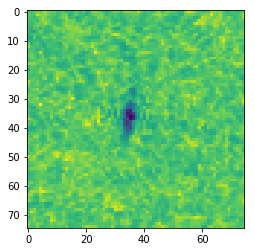

In [52]:
%matplotlib inline

sample_image = (X_train[0])

sample_image = np.reshape(sample_image, (75,75))
plt.imshow(sample_image)

In [54]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))

model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3), activation='relu'))

model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))

model1.add(BatchNormalization())
model1.add(Conv2D(256, (3, 3), activation='relu'))

model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu', use_bias=True, bias_initializer='zeros'))

model1.add(BatchNormalization())
model1.add(Dense(number_of_classes, activation='softmax'))


In [55]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [56]:
model1.fit(X_train, Y_train,
              batch_size=batch_size, validation_data=(X_test, Y_test),
              epochs=epochs,
                shuffle=True)

Train on 1300 samples, validate on 304 samples
Epoch 1/20
1300/1300 [==============================] - 401s - loss: 0.8422 - acc: 0.6854 - val_loss: 1.4916 - val_acc: 0.3355
Epoch 2/20
1300/1300 [==============================] - 333s - loss: 0.3594 - acc: 0.8469 - val_loss: 2.1992 - val_acc: 0.3355
Epoch 3/20
1300/1300 [==============================] - 304s - loss: 0.2565 - acc: 0.8962 - val_loss: 3.8136 - val_acc: 0.3355
Epoch 4/20
1300/1300 [==============================] - 303s - loss: 0.1743 - acc: 0.9354 - val_loss: 0.8535 - val_acc: 0.3355
Epoch 5/20
1300/1300 [==============================] - 283s - loss: 0.1499 - acc: 0.9385 - val_loss: 1.6131 - val_acc: 0.3355
Epoch 6/20
1300/1300 [==============================] - 283s - loss: 0.1294 - acc: 0.9500 - val_loss: 1.3706 - val_acc: 0.6645
Epoch 7/20
1300/1300 [==============================] - 283s - loss: 0.1445 - acc: 0.9446 - val_loss: 3.0644 - val_acc: 0.3355
Epoch 8/20
1300/1300 [==============================] - 284s - l

In [62]:
Y_pred = model1.predict(X_test)

In [82]:
for i in range(len(Y_pred)):
    Y_pred[i, :] = np.round(Y_pred[i, :])

In [87]:
#Precision: how many 1 are true 1?
#Recall: how many 0 are true 0? 
#F1Score: balance between those two

y_comp = confusion_matrix(Y_test[:, 1], Y_pred[:, 1])
precision = y_comp[1, 1] / (y_comp[0, 1] + y_comp[1, 1])
recall = y_comp[1, 1] / (y_comp[1, 0] + y_comp[1, 1])
accuracy = accuracy_score(Y_test[:, 1], Y_pred[:, 1])
f1score = 2 * precision * recall / (precision + recall)
print("AC:%.2f PR:%.2f RE:%.2f F1:%.2f" % (accuracy, precision, recall, f1score))

AC:0.69 PR:1.00 RE:0.08 F1:0.15


In [89]:
filename = ("model_%i_%i_%i_%i.h5" % (accuracy*100, precision*100, recall*100, f1score*100))
model1.save(filename)

In [ ]:
test = pd.read_json('test.json')

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)